In [1]:
import os
import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

%matplotlib inline

# import cv2
from sklearn.model_selection import train_test_split  # 分层分割数据集超方便的

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.preprocessing.image import load_img

/mnt/ml/anaconda35/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Set some parameters
im_width = 101
im_height = 101
im_chan = 1

basicpath = ''
path_train = basicpath + 'train/'
path_test = basicpath + 'test/'

path_train_images = path_train + 'images/'
path_train_masks = path_train + 'masks/'
path_test_images = path_test + 'images/'

print("Training imgs path:",path_train_images)
print("Masks of training imgs path:",path_train_masks)
print("Test imgs path:",path_test_images)


Training imgs path: train/images/
Masks of training imgs path: train/masks/
Test imgs path: test/images/


In [3]:
img_size_ori = 101
img_size_target = 101

def upsample(img):# not used
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    #res = np.zeros((img_size_target, img_size_target), dtype=img.dtype)
    #res[:img_size_ori, :img_size_ori] = img
    #return res
    
def downsample(img):# not used
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)
    #return img[:img_size_ori, :img_size_ori]

In [4]:
# Loading of training/testing ids and depths

train_df = pd.read_csv(basicpath+"train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv(basicpath+"depths.csv", index_col="id")
train_df = train_df.join(depths_df) # 每个id链接上相应的深度
test_df = depths_df[~depths_df.index.isin(train_df.index)]

print("number of train：",len(train_df))
print(train_df.head(5))
print(depths_df.head(5))
test_df.head(5)

number of train： 4000
              z
id             
575d24d81d  843
a266a2a9df  794
75efad62c1  468
34e51dba6a  727
4875705fb0  797
              z
id             
4ac19fb269  306
1825fadf99  157
f59821d067  305
5b435fad9d  503
e340e7bfca  783


,z
id,
353e010b7b,264
5439dbbddf,557
71bab9f311,846
52551f7a80,610
512d8d9997,577


In [5]:
train_df["images"] = [np.array(load_img(basicpath+"train/images/{}.png".format(idx), color_mode="grayscale")) / 255
                              for idx in tqdm_notebook(train_df.index)]

train_df["masks"] = [np.array(load_img(basicpath+"train/masks/{}.png".format(idx),color_mode="grayscale"))/ 255  
                              for idx in tqdm_notebook(train_df.index)]

A Jupyter Widget

A Jupyter Widget

In [6]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

def cov_to_class(val):    
    for i in range(0, 31):
        if val * 30 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)


/mnt/ml/anaconda35/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'Coverage class')

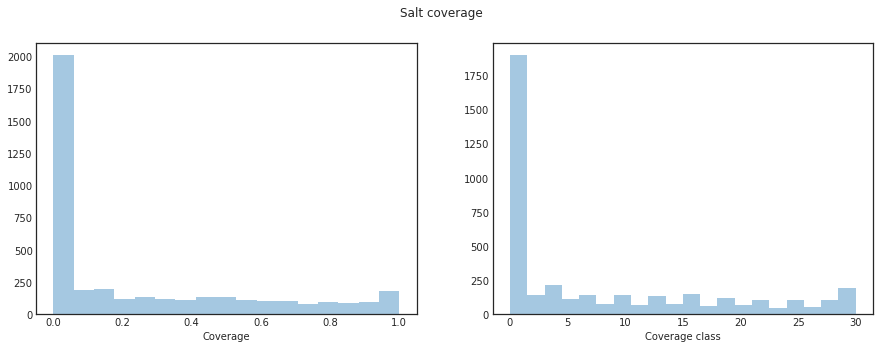

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=20, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

/mnt/ml/anaconda35/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Depth distribution')

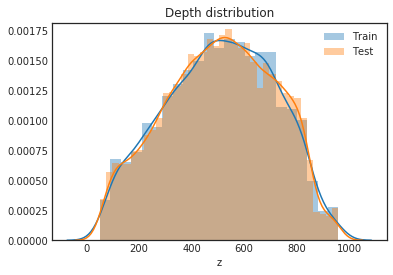

In [8]:
#Plotting the depth distributions¶

sns.distplot(train_df.z, label="Train")
sns.distplot(test_df.z, label="Test")
plt.legend()
plt.title("Depth distribution")

In [9]:
train_df.head(20)

,z,images,masks,coverage,coverage_class
id,,,,,
575d24d81d,843,"[[0.5254901960784314, 0.5137254901960784, 0.52...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000000,0
a266a2a9df,794,"[[0.3411764705882353, 0.3764705882352941, 0.33...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.504950,16
75efad62c1,468,"[[0.5686274509803921, 0.4666666666666667, 0.32...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.993334,30
34e51dba6a,727,"[[0.5411764705882353, 0.4745098039215686, 0.39...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.149201,5
4875705fb0,797,"[[0.06666666666666667, 0.0784313725490196, 0.0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.042839,2
782ae9b7e7,677,"[[0.6078431372549019, 0.6196078431372549, 0.61...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",0.225370,7
9842f69f8d,907,"[[0.4392156862745098, 0.4117647058823529, 0.4,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000000,0
aa94cfb806,754,"[[0.5058823529411764, 0.49019607843137253, 0.4...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",0.665817,20
50d3073821,810,"[[0.4666666666666667, 0.5333333333333333, 0.41...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",0.297030,9


In [10]:
# Create train/validation split stratified by salt coverage

# Create train/validation split stratified by salt coverage

ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    np.array(train_df.masks.tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.12, stratify=train_df.coverage_class, random_state= 1224)
# !!!! stratify 分层split的指标 覆盖比例的等级  后面还可以使用深度等级分层split

print(ids_train.shape)
print(x_train.shape)
print(y_train.shape)
print(cov_train.shape)
print(depth_train.shape)
type(x_train) # all are np.ndarray

(3520,)
(3520, 101, 101, 1)
(3520, 101, 101, 1)
(3520,)
(3520,)


numpy.ndarray

# 模型定义模块

In [11]:
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
import torch
from torchvision import models
import torchvision

In [12]:
# # 反卷积计算示例
# a_Deconv=nn.ConvTranspose2d(256,128,3,stride=2,\
#                                          padding=1,output_padding=1,bias=True, dilation=1)
# x=torch.randn(2,256,6,6)
# out=a_Deconv(x)
# out.shape

### 待改进模型:
* 使用更多的通道数
* SE-block改造
* Hypercolumn

* Loss改进 Focal loss 和 Lovasz-Softmax loss

In [13]:

class Conv2D_block(nn.Module):
    def __init__(self,C_in,C_out,filter_size=3,paddingType="SAME",ActionType="Relu"):
        super().__init__()
        
        padding={}
        if filter_size==3:
            padding["SAME"]=1
        if filter_size==1:
            padding["SAME"]=0
        padding["VALID"]=0
        
        self.Conv=nn.Conv2d(C_in, C_out, filter_size, stride=1,padding=padding[paddingType])
        self.BN=nn.BatchNorm2d(C_out)
        self.ActionType=ActionType
        
        # init operation
        self.reset_parameters(self.Conv)
        
    def reset_parameters(self,m): # to do: add more init methods according to the init policy
        nn.init.xavier_uniform_(m.weight.data)
        nn.init.constant_(m.bias.data,0)
    
    def forward(self,x):
        out=self.Conv(x)
        out=self.BN(out)
        if self.ActionType=="Relu":
            out=F.relu6(out,inplace=True)
        return out
            
class Residual_block(nn.Module):
    def __init__(self,C_in,C_out,filter_size=3,paddingType="SAME",ActionType="Relu"):
        super().__init__()
        
        self.BN=nn.BatchNorm2d(C_in)
        self.Conv1=Conv2D_block(C_in,C_out,filter_size,paddingType,ActionType)
        self.Conv2=Conv2D_block(C_out,C_out,filter_size,paddingType,ActionType=None)
        
        
    def forward(self,x):
        out=F.relu6(x,inplace=True)
        out=self.BN(out)
        out=self.Conv1(out)
        out=self.Conv2(out)
        out=out+x  # skip connection
        return out

class Eecoder_with_residual_block(nn.Module):
    
    def __init__(self,C_in,C_out,DropoutRatio = 0.5,filter_size=3,paddingType="SAME"):
        super().__init__()
        
        padding={}
        if filter_size==3:
            padding["SAME"]=1
        if filter_size==1:
            padding["SAME"]=0
        padding["VALID"]=0
        
        self.Conv_1=nn.Conv2d(C_in,C_out,filter_size,stride=1,padding=padding[paddingType])
        self.Res_1=Residual_block(C_out,C_out)
        self.Res_2=Residual_block(C_out,C_out)
    
        # init operation
        self.reset_parameters(self.Conv_1)
        
    def reset_parameters(self,m):
        nn.init.xavier_uniform_(m.weight.data)
        nn.init.constant_(m.bias.data,0)
        
    def forward(self,x):
        out=self.Conv_1(x)
        out=self.Res_1(out)
        out=self.Res_2(out)
        out=F.relu6(out,inplace=True)
        return out

class Decoder_with_residual_block(nn.Module):
    
    def __init__(self,C_in,C_out,DropoutRatio = 0.5,filter_size=3,paddingType="SAME"):
        super().__init__()
        
        padding={}
        if filter_size==3:
            padding["SAME"]=1
        if filter_size==1:
            padding["SAME"]=0
        padding["VALID"]=0  
        
        if paddingType=="VALID":
            output_padding=0
        else:
            output_padding=1
            
        self.Deconv_1=nn.ConvTranspose2d(C_in,C_out,filter_size, stride=2,\
                                         padding=padding[paddingType],output_padding=output_padding,bias=True, dilation=1)
        self.Dropout=nn.Dropout(DropoutRatio)
        self.Conv_1=nn.Conv2d(C_in,C_out,filter_size,stride=1,padding=1)
        self.Res_1=Residual_block(C_out,C_out)
        self.Res_2=Residual_block(C_out,C_out)
        
        # init operation
        self.reset_parameters(self.Conv_1)
        self.reset_parameters(self.Deconv_1)
        
    def reset_parameters(self,m):
        nn.init.xavier_uniform_(m.weight.data)
        nn.init.constant_(m.bias.data,0)        
        
    
    def forward(self,x,skipx):
        out=self.Deconv_1(x)
        out=torch.cat([out,skipx],dim=1)
        out=self.Dropout(out)
        
        out=self.Conv_1(out)
        out=self.Res_1(out)
        out=self.Res_2(out)
        out=F.relu6(out,inplace=True)
        return out
        
class Middle_with_residual_block(nn.Module):
    
    def __init__(self,C_in,C_out,DropoutRatio = 0.5,filter_size=3,paddingType="SAME"):
        super().__init__()
        
        padding={}
        if filter_size==3:
            padding["SAME"]=1
        if filter_size==1:
            padding["SAME"]=0
        padding["VALID"]=0
            
        self.Conv_1=nn.Conv2d(C_in,C_out,filter_size,stride=1,padding=padding[paddingType])
        self.Res_1=Residual_block(C_out,C_out)
        self.Res_2=Residual_block(C_out,C_out)

        self.reset_parameters(self.Conv_1)
        
    def reset_parameters(self,m):
        nn.init.xavier_uniform_(m.weight.data)
        nn.init.constant_(m.bias.data,0)           

    def forward(self,x):
        out=self.Conv_1(x)
        out=self.Res_1(out)
        out=self.Res_2(out)
        out=F.relu6(out,inplace=True)
        return out
    
class U_net_with_residual(nn.Module):
    
    def __init__(self,filter_num=16,DropoutRatio = 0.5,filter_size=3,paddingType="SAME"):
        super().__init__()
        
        self.Dropout_1=nn.Dropout(DropoutRatio/2)
        self.Dropout_2=nn.Dropout(DropoutRatio)
        
        self.Encoder_L1=Eecoder_with_residual_block(im_chan,filter_num,DropoutRatio/2)
        self.Encoder_L2=Eecoder_with_residual_block(filter_num*1,filter_num*2,DropoutRatio)
        self.Encoder_L3=Eecoder_with_residual_block(filter_num*2,filter_num*4,DropoutRatio)
        self.Encoder_L4=Eecoder_with_residual_block(filter_num*4,filter_num*8,DropoutRatio)
        
        self.Middle=Middle_with_residual_block(filter_num*8,filter_num*16,DropoutRatio)
        
        self.Decoder_L4=Decoder_with_residual_block(filter_num*16,filter_num*8,DropoutRatio,paddingType="SAME")
        self.Decoder_L3=Decoder_with_residual_block(filter_num*8,filter_num*4,DropoutRatio,paddingType="VALID")
        self.Decoder_L2=Decoder_with_residual_block(filter_num*4,filter_num*2,DropoutRatio,paddingType="SAME")
        self.Decoder_L1=Decoder_with_residual_block(filter_num*2,filter_num*1,DropoutRatio,paddingType="VALID")
        
    
        self.Out=nn.Conv2d(filter_num,1,1,stride=1,padding=0)
        
    def forward(self,x):
        Encoder_L1=self.Encoder_L1(x)
        Pool_L1=F.max_pool2d(Encoder_L1,2, stride=2)
        Pool_L1=self.Dropout_1(Pool_L1)
        
        Encoder_L2=self.Encoder_L2(Pool_L1)
        Pool_L2=F.max_pool2d(Encoder_L2,2, stride=2)
        Pool_L2=self.Dropout_2(Pool_L2)
        
        Encoder_L3=self.Encoder_L3(Pool_L2)
        Pool_L3=F.max_pool2d(Encoder_L3,2, stride=2)
        Pool_L3=self.Dropout_2(Pool_L3)
        
        Encoder_L4=self.Encoder_L4(Pool_L3)
        Pool_L4=F.max_pool2d(Encoder_L4,2, stride=2)
        Pool_L4=self.Dropout_2(Pool_L4)
        
        Middle=self.Middle(Pool_L4)
        
        Summary=False
        if Summary:
            print("1:",Encoder_L1.shape)
            print("2:",Encoder_L2.shape)
            print("3:",Encoder_L3.shape)
            print("4:",Encoder_L4.shape)
            print("5:",Middle.shape)
        
        
        Decoder_L4=self.Decoder_L4(Middle,Encoder_L4)
        Decoder_L3=self.Decoder_L3(Decoder_L4,Encoder_L3)
        Decoder_L2=self.Decoder_L2(Decoder_L3,Encoder_L2)
        Decoder_L1=self.Decoder_L1(Decoder_L2,Encoder_L1)
        
        if Summary:
            print("6:",Decoder_L4.shape)
            print("7:",Decoder_L3.shape)
            print("8:",Decoder_L2.shape)
            print("9:",Decoder_L1.shape)
            
        logits=self.Dropout_1(Decoder_L1)
        logits=self.Out(logits)
        #loits=F.sigmoid(logits)
        
        if Summary:
            print("10:",logits.shape)
        
        return logits
        

In [14]:
# model=U_net_with_residual(32)
# # print(model)

In [15]:
# import time
# x=torch.randn(32,1,101,101)
# model.train()
# since=time.time()
# logits=model(x)
# escaped_time=time.time()-since
# escaped_time

In [16]:
# #############################################
# ##  网络架构及Pytorch版本的Fine-tune手法   ##
# #############################################


# from torch import nn
# from torch.nn import functional as F
# import torch
# from torchvision import models
# import torchvision


# def conv3x3(in_, out):
#     return nn.Conv2d(in_, out, 3, padding=1)


# class ConvRelu(nn.Module):
#     def __init__(self, in_, out):
#         super().__init__()
#         self.conv = conv3x3(in_, out)
#         self.activation = nn.ReLU(inplace=True)

#     def forward(self, x):
#         x = self.conv(x)
#         x = self.activation(x)
#         return x


# class DecoderBlock(nn.Module):
#     def __init__(self, in_channels, middle_channels, out_channels):
#         super().__init__()

#         self.block = nn.Sequential(
#             ConvRelu(in_channels, middle_channels),
#             nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
#             nn.ReLU(inplace=True)
#         )

#     def forward(self, x):
#         return self.block(x)


# class UNet11(nn.Module):
#     def __init__(self, num_filters=32, pretrained=False):
#         """
#         :param num_classes:
#         :param num_filters:
#         :param pretrained:
#             False - no pre-trained network is used
#             True  - encoder is pre-trained with VGG11
#         """
#         super().__init__()
#         self.pool = nn.MaxPool2d(2, 2)

#         self.encoder = models.vgg11(pretrained=pretrained).features

#         self.relu = self.encoder[1]
#         #print(self.relu)   # output ==> RELU(inplace)
#         self.conv1 = self.encoder[0]
#         self.conv2 = self.encoder[3]
#         self.conv3s = self.encoder[6]
#         self.conv3 = self.encoder[8]
#         self.conv4s = self.encoder[11]
#         self.conv4 = self.encoder[13]
#         self.conv5s = self.encoder[16]
#         self.conv5 = self.encoder[18]

#         self.center = DecoderBlock(num_filters * 8 * 2, num_filters * 8 * 2, num_filters * 8)
#         self.dec5 = DecoderBlock(num_filters * (16 + 8), num_filters * 8 * 2, num_filters * 8)
#         self.dec4 = DecoderBlock(num_filters * (16 + 8), num_filters * 8 * 2, num_filters * 4)
#         self.dec3 = DecoderBlock(num_filters * (8 + 4), num_filters * 4 * 2, num_filters * 2)
#         self.dec2 = DecoderBlock(num_filters * (4 + 2), num_filters * 2 * 2, num_filters)
#         self.dec1 = ConvRelu(num_filters * (2 + 1), num_filters)

#         self.final = nn.Conv2d(num_filters, 1, kernel_size=1)  # 1x1卷积 输出是1通道

#     def forward(self, x):
#         conv1 = self.relu(self.conv1(x))
#         conv2 = self.relu(self.conv2(self.pool(conv1)))
#         conv3s = self.relu(self.conv3s(self.pool(conv2)))
#         conv3 = self.relu(self.conv3(conv3s))
#         conv4s = self.relu(self.conv4s(self.pool(conv3)))
#         conv4 = self.relu(self.conv4(conv4s))
#         conv5s = self.relu(self.conv5s(self.pool(conv4)))
#         conv5 = self.relu(self.conv5(conv5s))

#         center = self.center(self.pool(conv5))

#         dec5 = self.dec5(torch.cat([center, conv5], 1))
#         dec4 = self.dec4(torch.cat([dec5, conv4], 1))
#         dec3 = self.dec3(torch.cat([dec4, conv3], 1))
#         dec2 = self.dec2(torch.cat([dec3, conv2], 1))
#         dec1 = self.dec1(torch.cat([dec2, conv1], 1))
#         return self.final(dec1)


# def unet11(pretrained=False, **kwargs):
#     """
#     pretrained:
#             False - no pre-trained network is used
#             True  - encoder is pre-trained with VGG11
#             carvana - all weights are pre-trained on
#                 Kaggle: Carvana dataset https://www.kaggle.com/c/carvana-image-masking-challenge
#     """
#     if pretrained== True:
#         model = UNet11(pretrained=pretrained, **kwargs)
#     else:
#         model= UNet11(pretrained=False, **kwargs)
    
#     #  根据 pretrained 加载 'carvana'数据集上训练好的网络全部权重
#     if pretrained == 'carvana':
#         state = torch.load('TernausNet.pt',map_location={'cuda:0': 'cpu'})  #
#         model.load_state_dict(state['model']) #,map_location='cpu'
        
#     return model


# class DecoderBlockV2(nn.Module):
#     def __init__(self, in_channels, middle_channels, out_channels, is_deconv=True):
#         super(DecoderBlockV2, self).__init__()
#         self.in_channels = in_channels

#         if is_deconv:
#             """
#                 Paramaters for Deconvolution were chosen to avoid artifacts, following
#                 link https://distill.pub/2016/deconv-checkerboard/
#             """

#             self.block = nn.Sequential(
#                 ConvRelu(in_channels, middle_channels),
#                 nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=4, stride=2,
#                                    padding=1),
#                 nn.ReLU(inplace=True)
#             )
#         else:
#             self.block = nn.Sequential(
#                 nn.Upsample(scale_factor=2, mode='bilinear'),
#                 ConvRelu(in_channels, middle_channels),
#                 ConvRelu(middle_channels, out_channels),
#             )

#     def forward(self, x):
#         return self.block(x)


# class AlbuNet(nn.Module):
#     """
#         UNet (https://arxiv.org/abs/1505.04597) with Resnet34(https://arxiv.org/abs/1512.03385) encoder

#         Proposed by Alexander Buslaev: https://www.linkedin.com/in/al-buslaev/

#         """

#     def __init__(self, num_classes=1, num_filters=32, pretrained=False, is_deconv=False):
#         """
#         :param num_classes:
#         :param num_filters:
#         :param pretrained:
#             False - no pre-trained network is used
#             True  - encoder is pre-trained with resnet34
#         :is_deconv:
#             False: bilinear interpolation is used in decoder
#             True: deconvolution is used in decoder
#         """
#         super().__init__()
#         self.num_classes = num_classes

#         self.pool = nn.MaxPool2d(2, 2)

#         self.encoder = torchvision.models.resnet34(pretrained=pretrained)

#         self.relu = nn.ReLU(inplace=True)

#         self.conv1 = nn.Sequential(self.encoder.conv1,
#                                    self.encoder.bn1,
#                                    self.encoder.relu,
#                                    self.pool)

#         self.conv2 = self.encoder.layer1

#         self.conv3 = self.encoder.layer2

#         self.conv4 = self.encoder.layer3

#         self.conv5 = self.encoder.layer4

#         self.center = DecoderBlockV2(512, num_filters * 8 * 2, num_filters * 8, is_deconv)

#         self.dec5 = DecoderBlockV2(512 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv)
#         self.dec4 = DecoderBlockV2(256 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv)
#         self.dec3 = DecoderBlockV2(128 + num_filters * 8, num_filters * 4 * 2, num_filters * 2, is_deconv)
#         self.dec2 = DecoderBlockV2(64 + num_filters * 2, num_filters * 2 * 2, num_filters * 2 * 2, is_deconv)
#         self.dec1 = DecoderBlockV2(num_filters * 2 * 2, num_filters * 2 * 2, num_filters, is_deconv)
#         self.dec0 = ConvRelu(num_filters, num_filters)
#         self.final = nn.Conv2d(num_filters, num_classes, kernel_size=1)

#     def forward(self, x):
#         conv1 = self.conv1(x)
#         conv2 = self.conv2(conv1)
#         conv3 = self.conv3(conv2)
#         conv4 = self.conv4(conv3)
#         conv5 = self.conv5(conv4)

#         center = self.center(self.pool(conv5))

#         dec5 = self.dec5(torch.cat([center, conv5], 1))

#         dec4 = self.dec4(torch.cat([dec5, conv4], 1))
#         dec3 = self.dec3(torch.cat([dec4, conv3], 1))
#         dec2 = self.dec2(torch.cat([dec3, conv2], 1))
#         dec1 = self.dec1(dec2)
#         dec0 = self.dec0(dec1)

#         if self.num_classes > 1:
#             x_out = F.log_softmax(self.final(dec0), dim=1)
#         else:
#             x_out = self.final(dec0)

#         return x_out


# class UNet16(nn.Module):
#     def __init__(self, num_classes=1, num_filters=32, pretrained=False, is_deconv=False):
#         """
#         :param num_classes:
#         :param num_filters:
#         :param pretrained:
#             False - no pre-trained network used
#             True - encoder pre-trained with VGG16
#         :is_deconv:
#             False: bilinear interpolation is used in decoder
#             True: deconvolution is used in decoder
#         """
#         super().__init__()
#         self.num_classes = num_classes

#         self.pool = nn.MaxPool2d(2, 2)

#         self.encoder = torchvision.models.vgg16(pretrained=pretrained).features

#         self.relu = nn.ReLU(inplace=True)

#         self.conv1 = nn.Sequential(self.encoder[0],
#                                    self.relu,
#                                    self.encoder[2],
#                                    self.relu)

#         self.conv2 = nn.Sequential(self.encoder[5],
#                                    self.relu,
#                                    self.encoder[7],
#                                    self.relu)

#         self.conv3 = nn.Sequential(self.encoder[10],
#                                    self.relu,
#                                    self.encoder[12],
#                                    self.relu,
#                                    self.encoder[14],
#                                    self.relu)

#         self.conv4 = nn.Sequential(self.encoder[17],
#                                    self.relu,
#                                    self.encoder[19],
#                                    self.relu,
#                                    self.encoder[21],
#                                    self.relu)

#         self.conv5 = nn.Sequential(self.encoder[24],
#                                    self.relu,
#                                    self.encoder[26],
#                                    self.relu,
#                                    self.encoder[28],
#                                    self.relu)

#         self.center = DecoderBlockV2(512, num_filters * 8 * 2, num_filters * 8, is_deconv)

#         self.dec5 = DecoderBlockV2(512 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv)
#         self.dec4 = DecoderBlockV2(512 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv)
#         self.dec3 = DecoderBlockV2(256 + num_filters * 8, num_filters * 4 * 2, num_filters * 2, is_deconv)
#         self.dec2 = DecoderBlockV2(128 + num_filters * 2, num_filters * 2 * 2, num_filters, is_deconv)
#         self.dec1 = ConvRelu(64 + num_filters, num_filters)
#         self.final = nn.Conv2d(num_filters, num_classes, kernel_size=1)

#     def forward(self, x):
#         conv1 = self.conv1(x)
#         conv2 = self.conv2(self.pool(conv1))
#         conv3 = self.conv3(self.pool(conv2))
#         conv4 = self.conv4(self.pool(conv3))
#         conv5 = self.conv5(self.pool(conv4))

#         center = self.center(self.pool(conv5))

#         dec5 = self.dec5(torch.cat([center, conv5], 1))

#         dec4 = self.dec4(torch.cat([dec5, conv4], 1))
#         dec3 = self.dec3(torch.cat([dec4, conv3], 1))
#         dec2 = self.dec2(torch.cat([dec3, conv2], 1))
#         dec1 = self.dec1(torch.cat([dec2, conv1], 1))

#         if self.num_classes > 1:
#             x_out = F.log_softmax(self.final(dec1), dim=1)
#         else:
#             x_out = self.final(dec1)

#         return x_out


# 指标计算

In [17]:
thresholds = np.array([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])

def iou(img_true, img_pred):
    i = np.sum((img_true*img_pred) >0)
    u = np.sum((img_true + img_pred) >0)
    if u == 0:
        return u
    return i/u

def iou_metric(imgs_true, imgs_pred):
    num_images = len(imgs_true)
    scores = np.zeros(num_images)
    
    for i in range(num_images):
        if imgs_true[i].sum() == imgs_pred[i].sum() == 0:
            scores[i] = 1
        else:
            scores[i] = (thresholds <= iou(imgs_true[i], imgs_pred[i])).mean()
            
    return scores.mean()

# 准备训练数据并训练

In [18]:
#Data augmentation
x_train2 = np.transpose(np.append(x_train, [np.fliplr(x) for x in x_train], axis=0),(0,3,1,2)).astype(np.float32)
y_train2 = np.transpose(np.append(y_train, [np.fliplr(x) for x in y_train], axis=0),(0,3,1,2)).astype(np.float32)
x_valid2 = np.transpose(x_valid,(0,3,1,2)).astype(np.float32)
y_valid2 = np.transpose(y_valid,(0,3,1,2)).astype(np.float32)

print(x_train2.shape)
print(y_train2.shape)
print(x_valid2.shape)
print(y_valid2.shape)  # !!!不要对valid进行数据增强
print(type(x_train2[0,0,0,0]))
print(type(x_valid2[0,0,0,0]))

(7040, 1, 101, 101)
(7040, 1, 101, 101)
(480, 1, 101, 101)
(480, 1, 101, 101)
<class 'numpy.float32'>
<class 'numpy.float32'>


In [19]:
# 自定义一个Pytorch的数据加载器,必须继承自torch.utils.data.Dataset
# https://stackoverflow.com/questions/50052295/how-do-you-load-images-into-pytorch-dataloader

class saltIDDataset(torch.utils.data.Dataset):

    def __init__(self,preprocessed_images,train=True, preprocessed_masks=None):
        """
        Args:
            text_file(string): path to text file
            root_dir(string): directory with all train images
        """
        self.train = train
        self.images = preprocessed_images
        if self.train:
            self.masks = preprocessed_masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = None
        if self.train:
            mask = self.masks[idx]
        return (image, mask)

In [20]:
salt_ID_dataset_train = saltIDDataset(x_train2, 
                                      train=True, 
                                      preprocessed_masks=y_train2)

salt_ID_dataset_val = saltIDDataset(x_valid2, 
                                      train=True, 
                                      preprocessed_masks=y_valid2)

batch_size = 32

train_loader = torch.utils.data.DataLoader(dataset=salt_ID_dataset_train, 
                                           batch_size=batch_size, 
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=salt_ID_dataset_val, 
                                           batch_size=batch_size, 
                                           shuffle=False)

print("Trainng samples:",train_loader.dataset.__len__())
print("Validation samples:",val_loader.dataset.__len__())

Trainng samples: 7040
Validation samples: 480


In [21]:
class ArgParser(object):
    def __init__(self):
        
        self.MaxEpoch=90
        self.LR_Policy="ReduceLROnPlateau" #"MultiStage"
        
        self.n_gpus=1
        
        self.load_pretrained_model=False
        self.pretarined_model_path="Results"
        
        self.device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        self.start_save_epoch=70
        self.save_step=2

In [22]:
# class DiceLoss(nn.Module):
#     def __init__(self, smooth=0, eps=1e-7):
#         super(DiceLoss, self).__init__()
#         self.smooth = smooth
#         self.eps = eps

#     def forward(self, output, target):
#         return 1 - (2 * torch.sum(output * target) + self.smooth) / (
#                 torch.sum(output) + torch.sum(target) + self.smooth + self.eps)

In [23]:
def LearningRateAdjust(model,LR_Policy,optimizer,cur_epoch,cur_epoch_metirc,args):
    if LR_Policy=="MultiSatge":
        if cur_epoch==1:
            lr=0.005
        elif cur_epoch==50:
            lr=0.001
        elif cur_epoch==65:
            lr=0.0005
        elif cur_epoch==75:
            lr=0.0001
        else:
            return
    
    # -----------------
    global last_best_epoch_metric,patience,track_epoch,lr_factor,cur_lr,min_lr
    
    if LR_Policy=="ReduceLROnPlateau":
        if cur_epoch_metirc > last_best_epoch_metric:
            last_best_epoch_metric=cur_epoch_metirc
            track_epoch=0
            # save best fund model
            print("save best fund model")
            save_checkpoint(model.state_dict(), True, args.pretarined_model_path,args)
            
            return 
        
        if cur_epoch_metirc<=last_best_epoch_metric and track_epoch<patience:
            track_epoch=1+track_epoch
            
            return
        
        else:
            lr=max(cur_lr*lr_factor,min_lr)
            print("adjust learnig rate from {} to {}".format(cur_lr,lr))
            track_epoch=0
            cur_lr=lr
            
            print("*******")
            for param_group in optimizer.param_groups:
                print("Adjust lr to {}".format(lr))
                param_group["lr"]=lr

In [24]:

def custom_weights_init(m):
    pass

In [26]:
import time
import shutil
        

def save_checkpoint(state, is_best, path,args):
    save_path=os.path.join(path,'saved_Gpu_model_state.pt')
    torch.save(state, save_path)
    if is_best:
        shutil.copyfile(save_path, 
                        os.path.join(args.pretarined_model_path ,'best_Gpu_model_state.pt'))

    
def train(model,train_loader,optimizer,criterion,args,epoch,class_weights,Dice_loss):
    since=time.time()
    model.train()
    train_losses = []
    
    for batch_idx, (images, masks) in enumerate(train_loader):
        
        images, masks = images.to(args.device), masks.to(args.device)
        images, masks = Variable(images), Variable(masks)
        
        logits = model(images)
        #print(model.Encoder_L1.Conv_1.bias.data)  # check init 
        loss = criterion(logits, masks)
#         loss_2=Dice_loss(torch.sigmoid(logits), masks)
        
#         combine_cofficient=0.5
#         loss=combine_cofficient*loss_1+(1-combine_cofficient)*loss_2
        
        train_losses.append(loss.data)
        
        #dice_loss = bioloss.dice_error(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
    now=time.time()
    mean_loss=np.mean(train_losses)
    print("Epoch {}### Mean Train Loss:{},escaped time:{}".format(epoch,mean_loss,now-since))
    return mean_loss

def test(model,test_loader,criterion,args,epoch,class_weights,Dice_loss):
    since=time.time()
    model.eval()
    test_losses = []
    
    val_acc=[]
    
    global batch_size
    for batch_idx, (images, masks) in enumerate(test_loader):
        
        images, masks = images.to(args.device), masks.to(args.device)
        images, masks = Variable(images), Variable(masks)
        
        logits = model(images)
        
        loss = criterion(logits, masks)
#         loss_2=Dice_loss(torch.sigmoid(logits), masks)
        
#         combine_cofficient=0.5
#         loss=combine_cofficient*loss_1+(1-combine_cofficient)*loss_2
        
        test_losses.append(loss.data)
        #dice_loss = bioloss.dice_error(output, target)
        tmp=((torch.sigmoid(logits)>=0.5).to(torch.float32)==masks).to(torch.float32)
        val_acc.append(torch.sum(tmp)/(batch_size*101*101))
        
        
    now=time.time()
    mean_loss=np.mean(test_losses)
    cur_metric=np.mean(val_acc)
    print("Epoch {}### Mean Val Loss:{}, Mean metric:{}, escaped time:{}".format(epoch,mean_loss,cur_metric,now-since))
            
    return mean_loss,cur_metric

In [27]:

# ------- 全局变量 ----------
train_losses_history=[]
val_losses_history=[]

last_best_epoch_metric=0,
patience=5  # 5-7 比较合适
track_epoch=0
lr_factor=0.5
cur_lr=0.001
init_lr=cur_lr
min_lr=0.000005
start_epoch=0

def main():
    
    args=ArgParser()
    
    torch.cuda.manual_seed_all(4200)# 设置全局固定随机种子方便复现
    np.random.seed(133700)
    
    model=U_net_with_residual(32) # 16 is the basic filter_nums, for controlling the width of U-Net
    
    
    if args.load_pretrained_model==True:
        state = torch.load('Results/best_Gpu_model_state.pt')#,map_location={'cuda:0': 'cpu'})  #
        model.load_state_dict(state) #,map_location='cpu'
    else:
        model.apply(custom_weights_init)    
    
    # deploy model to GPU or CPU
    model.to(args.device)
    
    # -------------------------------------------------------------------------------- #
    optimizer = torch.optim.Adam(model.parameters(), lr=init_lr)
    for param_group in optimizer.param_groups:
                print("Adjust lr to {}".format(init_lr))
                param_group["lr"]=init_lr
    #optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
    
    #criterion = nn.CrossEntropyLoss()
    criterion = nn.BCEWithLogitsLoss()
    # -------------------------------------------------------------------------------- #
    Dice_loss=DiceLoss(smooth=1)
    
    
    class_weights=[0.5,0.5] 
    
    best_metric=100  # 注意指标的大小与性能的关系
    
    for epoch in range(start_epoch,args.MaxEpoch):
       
        mean_train_loss_=train(model,train_loader,optimizer,criterion,args,epoch,class_weights,Dice_loss)
        train_losses_history.append(mean_train_loss_)
        
        mean_val_loss_,cur_metric=test(model,val_loader,criterion,args,epoch,class_weights,Dice_loss)
        val_losses_history.append(mean_val_loss_)
        
        LearningRateAdjust(model,args.LR_Policy,optimizer,epoch,cur_metric,args)
            
        if  epoch>=args.start_save_epoch :
            if mean_val_loss_<best_metric:
                best_metric=mean_val_loss_
                is_best=True
                
            else:
                is_best=False
                if epoch % args.save_step ==0:
                    torch.save(model.state_dict(),"Results/MM_{}.pt".format(epoch))
    torch.save(model.state_dict(),"Results/MM.pt")
    return model

   
    

In [ ]:
model=main()

Adjust lr to 0.001
Epoch 0### Mean Train Loss:0.3572857975959778,escaped time:47.122714042663574
Epoch 0### Mean Val Loss:0.27232661843299866, Mean metric:0.8960040211677551, escaped time:0.9011504650115967
save best fund model
Epoch 1### Mean Train Loss:0.270992636680603,escaped time:47.054497718811035
Epoch 1### Mean Val Loss:0.3378552198410034, Mean metric:0.8445422053337097, escaped time:0.9030323028564453
Epoch 2### Mean Train Loss:0.2415509670972824,escaped time:47.05922055244446
Epoch 2### Mean Val Loss:0.26179736852645874, Mean metric:0.9177439212799072, escaped time:0.9067342281341553
save best fund model
Epoch 3### Mean Train Loss:0.23328740894794464,escaped time:47.06519103050232
Epoch 3### Mean Val Loss:0.21439287066459656, Mean metric:0.9184986352920532, escaped time:0.9051392078399658
save best fund model
Epoch 4### Mean Train Loss:0.22802704572677612,escaped time:47.02606916427612
Epoch 4### Mean Val Loss:0.27456551790237427, Mean metric:0.9018352627754211, escaped time:

Epoch 41### Mean Train Loss:0.11490730196237564,escaped time:47.03143286705017
Epoch 41### Mean Val Loss:0.17080731689929962, Mean metric:0.9395443201065063, escaped time:0.9098663330078125
Epoch 42### Mean Train Loss:0.113365538418293,escaped time:46.99455451965332
Epoch 42### Mean Val Loss:0.17177261412143707, Mean metric:0.9370954632759094, escaped time:0.9039907455444336
Epoch 43### Mean Train Loss:0.1152377650141716,escaped time:47.0077064037323
Epoch 43### Mean Val Loss:0.15040892362594604, Mean metric:0.9421871304512024, escaped time:0.9037237167358398
Epoch 44### Mean Train Loss:0.11416857689619064,escaped time:47.00193905830383
Epoch 44### Mean Val Loss:0.15839456021785736, Mean metric:0.9392060041427612, escaped time:0.9043722152709961
Epoch 45### Mean Train Loss:0.1115555688738823,escaped time:47.015647888183594
Epoch 45### Mean Val Loss:0.15298549830913544, Mean metric:0.9425675272941589, escaped time:0.9073455333709717
adjust learnig rate from 6.25e-05 to 3.125e-05
*******

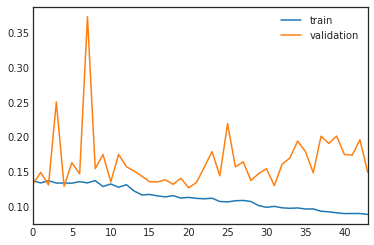

In [34]:
train_loss_series = pd.Series(train_losses_history)
val_loss_series = pd.Series(val_losses_history)
train_loss_series.plot(label="train")
val_loss_series.plot(label="validation")
plt.legend()

In [25]:
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
import torch
from torchvision import models
import torchvision

(480, 1, 101, 101)
(480, 1, 101, 101)
(480, 1, 101, 101)
(480, 1, 101, 101)
cost time: 0.9530937671661377


A Jupyter Widget

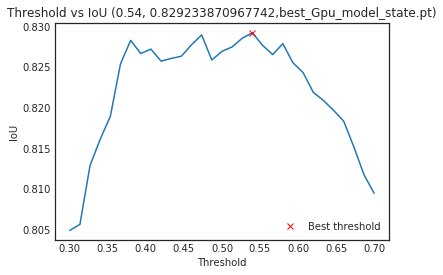

(480, 1, 101, 101)
(480, 1, 101, 101)
(480, 1, 101, 101)
(480, 1, 101, 101)
cost time: 0.9381184577941895


A Jupyter Widget

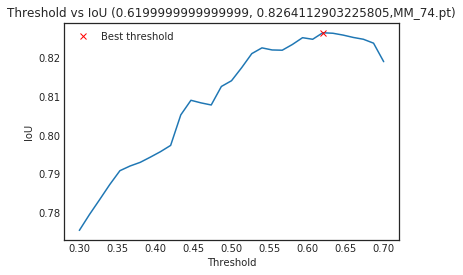

(480, 1, 101, 101)
(480, 1, 101, 101)
(480, 1, 101, 101)
(480, 1, 101, 101)
cost time: 0.9447686672210693


A Jupyter Widget

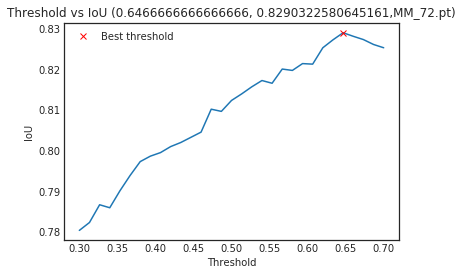

In [26]:
import os
MODELS_NAME=os.listdir("Results")

for model_name in MODELS_NAME:
    if model_name[0]!='M' and model_name[0] !='b':
        continue
    #model=U_net_with_residual(16)
    model=U_net_with_residual(32)#UNetResNet(encoder_depth=34,num_classes=1,num_filters=16, dropout_2d_ration=0.8,pretrained=False)


    state = torch.load('Results/{}'.format(model_name))#,map_location={'cuda:0': 'cpu'})  #
    model.load_state_dict(state) #,map_location='cpu'

    if torch.cuda.is_available():
        model=model.cuda()
    
    
    # ------------------------------------
    VAL_USE_SYM_FLAG=False

    x_valid_Sym=np.transpose(np.array([np.fliplr(x) for x in x_valid]),(0,3,1,2)).astype(np.float32)
    print(x_valid_Sym.shape)

    y_valid_Sym=np.zeros_like(x_valid_Sym).astype(np.float32)

    salt_ID_dataset_valid_Sym = saltIDDataset(x_valid_Sym, 
                                          train=True, 
                                          preprocessed_masks=y_valid_Sym)

    batch_size = 32

    valid_loader_Sym = torch.utils.data.DataLoader(dataset=salt_ID_dataset_valid_Sym, 
                                               batch_size=batch_size, 
                                               shuffle=False)

    mask_pred_valid_Sym = []
    model.eval()
    for images, masks in valid_loader_Sym:
        images = Variable(images.cuda())
    #     images = Variable(images)
        y_preds = model(images)
        y_preds=F.sigmoid(y_preds)


        for i, _ in enumerate(images):
            y_pred = y_preds[i] 
            y_pred = y_pred.cpu().data.numpy()
            mask_pred_valid_Sym.append(y_pred[:,:,::-1])



    mask_pred_valid_Sym=np.array(mask_pred_valid_Sym) 
    print(mask_pred_valid_Sym.shape)

    VAL_USE_SYM_FLAG=True



    import time
    since=time.time()

    mask_pred_valid = []
    mask_truth_valid=[]

    model.eval()
    for images, masks in val_loader:
        images = Variable(images.cuda())
    #     images = Variable(images)
        y_preds = model(images)
        y_preds=F.sigmoid(y_preds)

        for i, _ in enumerate(images):
            y_pred = y_preds[i] 
            y_pred = y_pred.cpu().data.numpy()
            mask_pred_valid.append(y_pred)
            mask_truth_valid.append(masks[i].numpy())


    mask_pred_valid=np.array(mask_pred_valid)
    mask_truth_valid=np.array(mask_truth_valid)       
    print(mask_truth_valid.shape)
    print(mask_truth_valid.shape)

    if VAL_USE_SYM_FLAG:
        mask_pred_valid=0.5*(mask_pred_valid+mask_pred_valid_Sym)

    print("cost time:",time.time()-since)
    
    import gc
    del x_valid_Sym
    del y_valid_Sym
    del salt_ID_dataset_valid_Sym
    del valid_loader_Sym
    del model
    gc.collect()
    
    
        # 将小于200个像素点的全部截掉  在测试阶段也会使用该过滤函数 
    def filter_image(img):
        if img.sum() < 200:
            return np.zeros(img.shape)
        else:
            return img

    ## Scoring for last model
    thresholds = np.linspace(0.3, 0.7, 31)
    ious = np.array([iou_metric(y_valid.reshape((-1, img_size_target, img_size_target)),
                                [filter_image(img) for img in mask_pred_valid > threshold]) 
                       for threshold in tqdm_notebook(thresholds)])



    threshold_best_index = np.argmax(ious) 
    iou_best = ious[threshold_best_index]
    threshold_best = thresholds[threshold_best_index]

    plt.plot(thresholds, ious)
    plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
    plt.xlabel("Threshold")
    plt.ylabel("IoU")
    plt.title("Threshold vs IoU ({}, {},{})".format(threshold_best, iou_best,model_name))
    plt.legend()
    plt.show()
    

# 准备测试数据并测试

In [27]:
model=U_net_with_residual(32)#UNetResNet(encoder_depth=34,num_classes=1,num_filters=16, dropout_2d_ration=0.8,pretrained=False)

model_name="best_Gpu_model_state.pt"
state = torch.load('Results/{}'.format(model_name))#,map_location={'cuda:0': 'cpu'})  #
model.load_state_dict(state) #,map_location='cpu'

if torch.cuda.is_available():
    model=model.cuda()

In [28]:
"""
used for converting the decoded image to rle mask
Fast compared to previous one
"""
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [29]:
x_test = np.array([(np.array(load_img("test/images/{}.png".format(idx), color_mode="grayscale"))) / 255 
                   for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

A Jupyter Widget

In [30]:
x_test.shape

(18000, 101, 101, 1)

In [31]:
x_test2=np.transpose(x_test,(0,3,1,2)).astype(np.float32)
print(x_test2.shape)
y_test2=np.zeros_like(x_test2).astype(np.float32)

salt_ID_dataset_test = saltIDDataset(x_test2, 
                                      train=True, 
                                      preprocessed_masks=y_test2)

batch_size = 32

test_loader = torch.utils.data.DataLoader(dataset=salt_ID_dataset_test, 
                                           batch_size=batch_size, 
                                           shuffle=False)

(18000, 1, 101, 101)


In [32]:
x_test_Sym=np.transpose(np.array([np.fliplr(x) for x in x_test]),(0,3,1,2)).astype(np.float32)
print(x_test_Sym.shape)

y_test_Sym=np.zeros_like(x_test_Sym).astype(np.float32)

salt_ID_dataset_test_Sym = saltIDDataset(x_test_Sym, 
                                      train=True, 
                                      preprocessed_masks=y_test_Sym)

batch_size = 32

test_loader_Sym = torch.utils.data.DataLoader(dataset=salt_ID_dataset_test_Sym, 
                                           batch_size=batch_size, 
                                           shuffle=False)

(18000, 1, 101, 101)


In [33]:
mask_pred_test_Sym = []

for images, masks in test_loader_Sym:
    images = Variable(images.cuda())
#     images = Variable(images)
    y_preds = model(images)
    y_preds=torch.sigmoid(y_preds)
    
    
    for i, _ in enumerate(images):
        y_pred = y_preds[i] 
        y_pred = y_pred.cpu().data.numpy()
        mask_pred_test_Sym.append(y_pred[:,:,::-1])
       
        
        
mask_pred_test_Sym=np.array(mask_pred_test_Sym) 
print(mask_pred_test_Sym.shape)


(18000, 1, 101, 101)


In [34]:
mask_pred_test = []

for images, masks in test_loader:
    images = Variable(images.cuda())
#     images = Variable(images)
    y_preds = model(images)
    y_preds=torch.sigmoid(y_preds)
    
    for i, _ in enumerate(images):
        y_pred = y_preds[i] 
        y_pred = y_pred.cpu().data.numpy()
        mask_pred_test.append(y_pred)
       

        
mask_pred_test=np.array(mask_pred_test) 
print(mask_pred_test.shape)
mask_pred_test=0.5*(mask_pred_test+mask_pred_test_Sym)

(18000, 1, 101, 101)


In [35]:
threshold_best=0.54

In [36]:
import time
t1 = time.time()
pred_dict = {idx: rle_encode(np.round(downsample(mask_pred_test[i]) > threshold_best)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}
t2 = time.time()

print(f"Usedtime = {t2-t1} s")

A Jupyter Widget


Usedtime = 5.283778190612793 s


In [37]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission_SSS.csv')

# CRF后处理(CPU模式下运行)

### 安装pydensecrf   
```shell
apt-get uppdate
source etc/profile 
conda install gxx_linux-64
pip install pydensecrf
```

In [4]:
import numpy as np
import pydensecrf.densecrf as dcrf
from skimage.io import imread, imsave
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral
from skimage.color import gray2rgb
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm_notebook
%matplotlib inline

In [5]:
def rle_decode(rle_mask):
    '''
    rle_mask: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = rle_mask.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(101*101, dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(101,101)

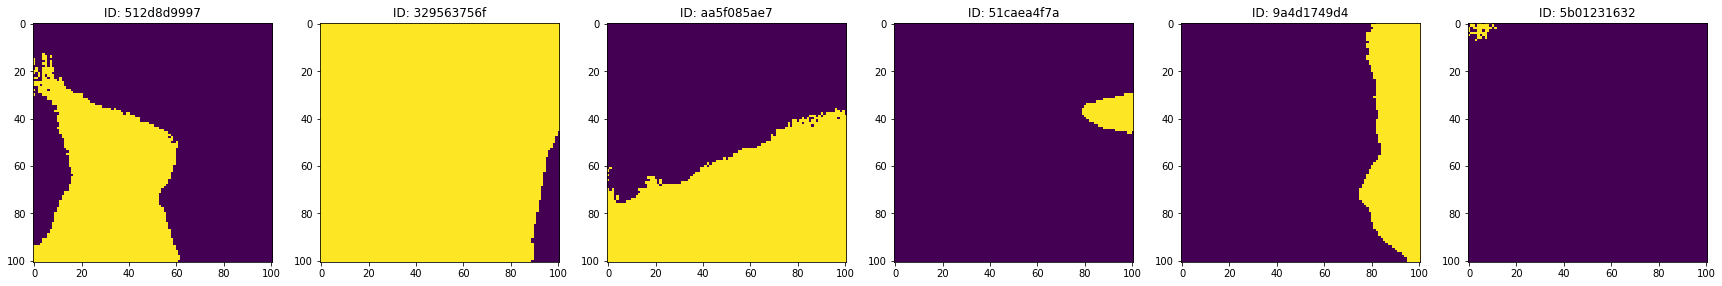

In [6]:
"""
reading and decoding the submission 

"""
df = pd.read_csv('submission_solution5.csv')
i = 0
j = 0
plt.figure(figsize=(30,15))
plt.subplots_adjust(bottom=0.2, top=0.8, hspace=0.2)  #adjust this to change vertical and horiz. spacings..
# Visualizing the predicted outputs
while True:
    if str(df.loc[i,'rle_mask'])!=str(np.nan):        
        decoded_mask = rle_decode(df.loc[i,'rle_mask'])
        plt.subplot(1,6,j+1)
        plt.imshow(decoded_mask)
        plt.title('ID: '+df.loc[i,'id'])
        j = j + 1
        if j>5:
            break
    i = i + 1

# Function to apply CRF

In [7]:
#Original_image = Image which has to labelled
#Mask image = Which has been labelled by some technique..
def crf(original_image, mask_img):
    
    # Converting annotated image to RGB if it is Gray scale
    if(len(mask_img.shape)<3):
        mask_img = gray2rgb(mask_img)

#     #Converting the annotations RGB color to single 32 bit integer
    annotated_label = mask_img[:,:,0] + (mask_img[:,:,1]<<8) + (mask_img[:,:,2]<<16)
    
#     # Convert the 32bit integer color to 0,1, 2, ... labels.
    colors, labels = np.unique(annotated_label, return_inverse=True)

    n_labels = 2
    
    #Setting up the CRF model
    d = dcrf.DenseCRF2D(original_image.shape[1], original_image.shape[0], n_labels)

    # get unary potentials (neg log probability)
    U = unary_from_labels(labels, n_labels, gt_prob=0.7, zero_unsure=False)
    d.setUnaryEnergy(U)

    # This adds the color-independent term, features are the locations only.
    d.addPairwiseGaussian(sxy=(3, 3), compat=3, kernel=dcrf.DIAG_KERNEL,
                      normalization=dcrf.NORMALIZE_SYMMETRIC)
        
    #Run Inference for 10 steps 
    Q = d.inference(10)

    # Find out the most probable class for each pixel.
    MAP = np.argmax(Q, axis=0)

    return MAP.reshape((original_image.shape[0],original_image.shape[1]))

In [8]:
test_path = 'TestData/images/'

# Visualizing the effect of applying CRF

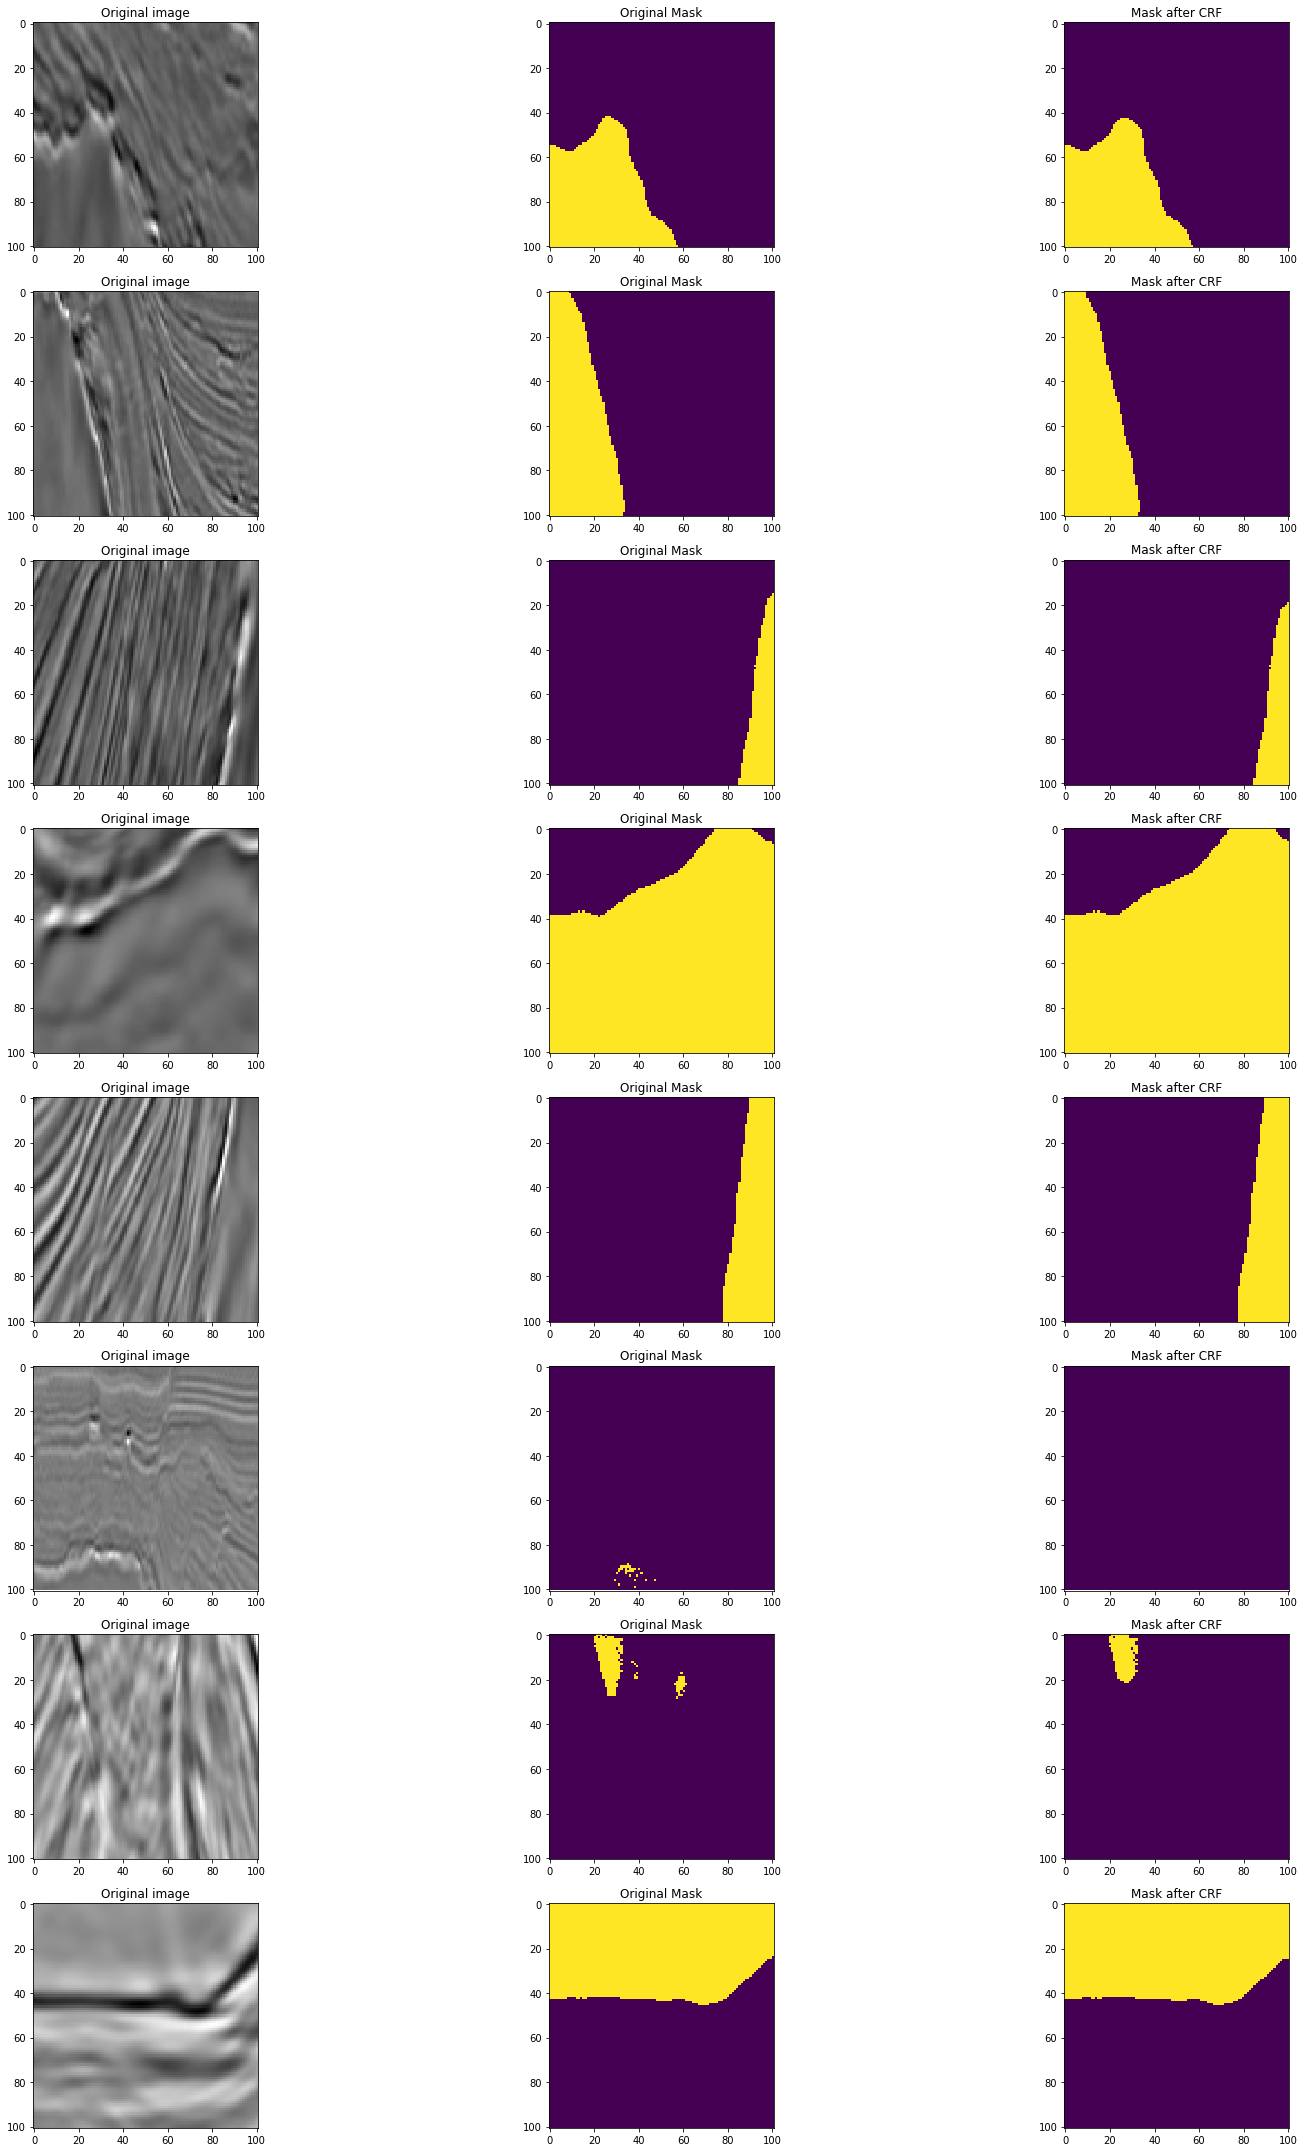

In [9]:
"""
visualizing the effect of applying CRF

"""
np.random.seed(100)
nImgs = 8
i = np.random.randint(1000)
j = 1
plt.figure(figsize=(30,30))
while True:
    if str(df.loc[i,'rle_mask'])!=str(np.nan):        
        decoded_mask = rle_decode(df.loc[i,'rle_mask'])        
        orig_img = imread(test_path+df.loc[i,'id']+'.png')
        #Applying CRF on FCN-16 annotated image
        crf_output = crf(orig_img,decoded_mask)
        plt.subplot(nImgs,4,4*j-3)
        plt.imshow(orig_img)
        plt.title('Original image')
        plt.subplot(nImgs,4,4*j-2)
        plt.imshow(np.fliplr(np.rot90(decoded_mask,k=3)))
        plt.title('Original Mask')
        plt.subplot(nImgs,4,4*j-1)
        plt.imshow(np.fliplr(np.rot90(crf_output,k=3)))
        plt.title('Mask after CRF')
        if j == nImgs:
            break
        else:
            j = j + 1
    i = i + 1
plt.tight_layout()

In [10]:
"""
used for converting the decoded image to rle mask

"""
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [12]:
"""
Applying CRF on the predicted mask 

"""
for i in tqdm_notebook(range(df.shape[0])):
    if str(df.loc[i,'rle_mask'])!=str(np.nan):        
        decoded_mask = rle_decode(df.loc[i,'rle_mask'])        
        orig_img = imread(test_path+df.loc[i,'id']+'.png')        
        crf_output = crf(orig_img,decoded_mask)
        df.loc[i,'rle_mask'] = rle_encode(crf_output)

A Jupyter Widget

In [13]:
df.to_csv('crf_correction.csv',index=False)

# FAQ:

## [Dice loss 与 F1 score的关系](https://dev.to/andys0975/what-is-dice-loss-for-image-segmentation-3p85)